# SVM Kernel Comparison — Tutorial + Experiments

Understanding SVM Kernel Choices: Linear, RBF, and Polynomial

Introduction
Support Vector Machines (SVMs) are supervised learning models that find a separating hyperplane between classes.
When data are not linearly separable, kernels let SVMs operate implicitly in higher-dimensional spaces so they can
still form linear separators in that transformed space. This tutorial explains three common kernels — Linear, RBF,
and Polynomial — and demonstrates their behaviour with visual examples and practical guidance for selection.

Why kernels matter
A kernel computes similarity between two points. Choosing a kernel determines the kinds of decision boundaries the
SVM can represent. The Linear kernel produces flat hyperplanes; the Polynomial kernel creates polynomial-shaped
boundaries controlled by degree; the RBF kernel produces local, flexible boundaries controlled by the gamma parameter.

Datasets used for illustration
We use three synthetic 2D datasets that highlight different challenges:
- Moons: two interleaving half-circles (nonlinear, curved).
- Circles: concentric circles (highly nonlinear).
- Blobs: Gaussian clusters (approximately linear separability).
These datasets allow clear visual comparisons of kernel behaviour.

Practical pipeline and hyperparameters
To ensure fair comparison, each SVM is trained inside a scikit-learn Pipeline that scales features using StandardScaler.
Important hyperparameters:
- C (regularization): larger C → less regularization → potentially more complex boundary.
- gamma (RBF): small gamma → smoother decision boundary; large gamma → more wiggly, possibly overfit.
- degree, coef0 (polynomial): control polynomial shape and offset.
We use GridSearchCV with 5-fold stratified cross-validation to select hyperparameters for each kernel independently.

Visualising decision boundaries and support vectors
For each dataset and kernel, decision regions are plotted on a dense grid and the learned support vectors are shown.
This provides an intuitive view of how flexible each kernel is and how support vectors concentrate near decision boundaries.

Key observations (expected)
- Linear kernel: performs well on blobs (linearly separable) and is fastest; fails on moons/circles.
- RBF kernel: very flexible and often performs best on nonlinear datasets; sensitive to gamma and C.
- Polynomial kernel: capable of curved boundaries; degree must be chosen carefully to avoid overfitting.

Recommendations / Rules of thumb
- Start with a Linear kernel for high-dimensional, sparse data.
- Use RBF as a strong default for low-dimensional nonlinear problems; tune gamma using cross-validation.
- Use Polynomial when you suspect polynomial relationships or interactions; keep degree small (2–3) unless justified.
- Always scale features before SVM training and use cross-validation to choose C and other hyperparameters.

Ethical considerations
Kernel choice affects accuracy and, in turn, downstream fairness and decisions. Poor model selection may harm
stakeholders; therefore document choices, test across subgroups, and report limitations transparently.



In [ ]:

# Imports all the required libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, joblib
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
np.random.seed(0)
OUTDIR = "/mnt/data/svm_submission_package/artifacts"
os.makedirs(OUTDIR, exist_ok=True)
PALETTE = ['#0072B2', '#D55E00']  # colorblind-friendly pair (blue, orange)
plt.rcParams['figure.figsize'] = (6,4)
print("Setup complete. Artifacts directory:", OUTDIR)


Setup complete. Artifacts directory: /mnt/data/svm_submission_package/artifacts


Setup complete. Artifacts directory: /mnt/data/svm_submission_package/artifacts


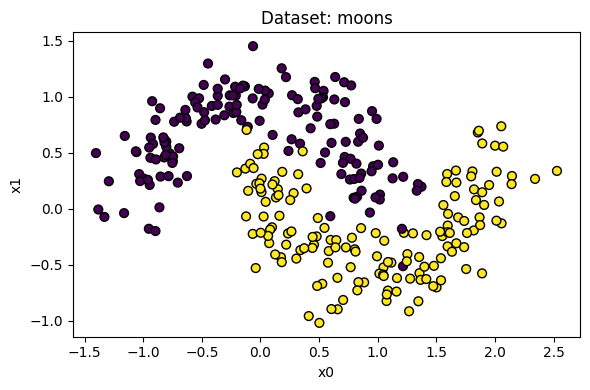

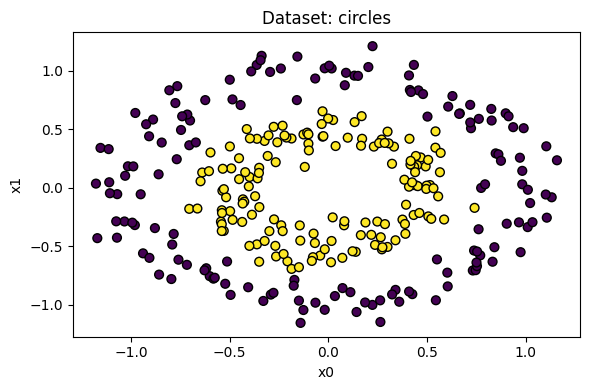

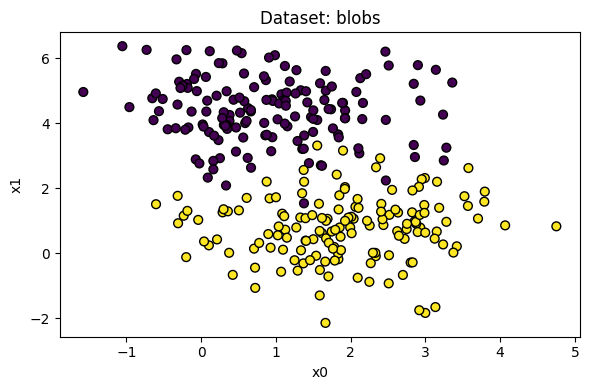

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, joblib
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
np.random.seed(0)
OUTDIR = "/mnt/data/svm_submission_package/artifacts"
os.makedirs(OUTDIR, exist_ok=True)
PALETTE = ['#0072B2', '#D55E00']  # colorblind-friendly pair (blue, orange)
plt.rcParams['figure.figsize'] = (6,4)
print("Setup complete. Artifacts directory:", OUTDIR)

# Generating datasets
RANDOM_STATE = 0
datasets = {
    'moons': make_moons(n_samples=300, noise=0.2, random_state=RANDOM_STATE),
    'circles': make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=RANDOM_STATE),
    'blobs': make_blobs(n_samples=300, centers=2, cluster_std=1.0, random_state=RANDOM_STATE)
}
for name,(X,y) in datasets.items():
    plt.figure(); plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=40); plt.title(f"Dataset: {name}"); plt.xlabel('x0'); plt.ylabel('x1'); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,f"dataset_{name}.png"), dpi='figure', bbox_inches='tight'); plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary_and_support(clf, X, y, title, savepath=None):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid).reshape(xx.shape)
    cmap = ListedColormap(PALETTE)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=40)
    svc = None
    if hasattr(clf, 'named_steps'):
        for step in clf.named_steps.values():
            if hasattr(step, 'support_'):
                svc = step
    else:
        if hasattr(clf, 'support_'): svc = clf
    if svc is not None:
        sv = svc.support_vectors_
        plt.scatter(sv[:,0], sv[:,1], facecolors='none', edgecolors='k', s=100, linewidths=1.2)
    plt.title(title); plt.xlabel('x0'); plt.ylabel('x1'); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi='figure', bbox_inches='tight')
    plt.show()

In [ ]:

param_grids = {
    'linear': {'svc__C': [0.01,0.1,1,10,100], 'svc__kernel':['linear']},
    'rbf': {'svc__C': [0.1,1,10,100], 'svc__gamma': ['scale',0.1,1,5], 'svc__kernel':['rbf']},
    'poly': {'svc__C': [0.1,1,10], 'svc__degree': [2,3], 'svc__gamma': ['scale',0.1,1], 'svc__coef0':[0.0,1.0], 'svc__kernel':['poly']}
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



Dataset: moons

-- Kernel: linear
Best params: {'svc__C': 0.01, 'svc__kernel': 'linear'}  | CV acc: 0.8666666666666666  | Test acc: 0.7777777777777778


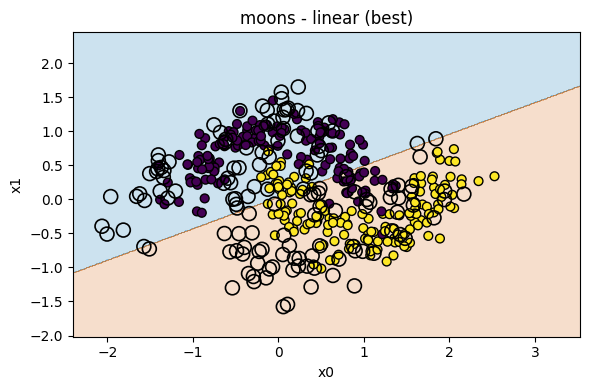

              precision    recall  f1-score   support

           0      0.791     0.756     0.773        45
           1      0.766     0.800     0.783        45

    accuracy                          0.778        90
   macro avg      0.778     0.778     0.778        90
weighted avg      0.778     0.778     0.778        90



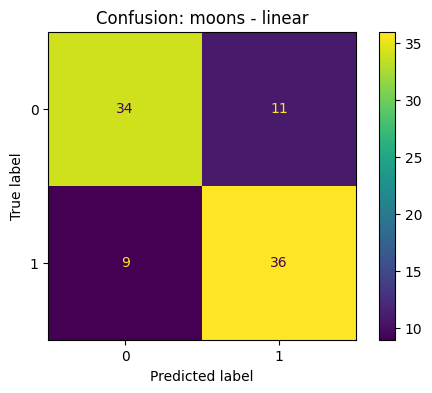


-- Kernel: rbf
Best params: {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}  | CV acc: 0.9857142857142858  | Test acc: 0.9777777777777777


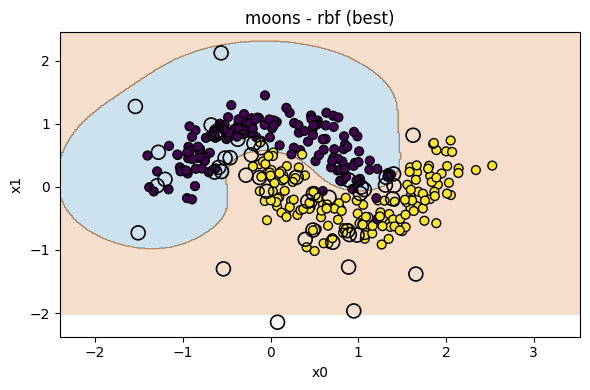

              precision    recall  f1-score   support

           0      0.978     0.978     0.978        45
           1      0.978     0.978     0.978        45

    accuracy                          0.978        90
   macro avg      0.978     0.978     0.978        90
weighted avg      0.978     0.978     0.978        90



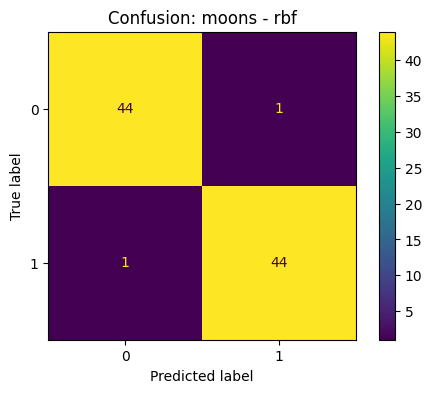


-- Kernel: poly
Best params: {'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}  | CV acc: 0.9857142857142858  | Test acc: 0.9666666666666667


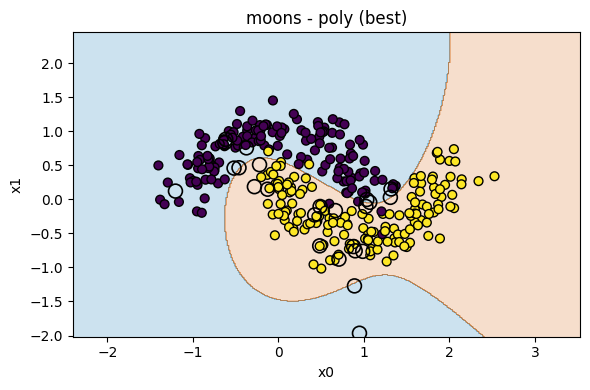

              precision    recall  f1-score   support

           0      0.977     0.956     0.966        45
           1      0.957     0.978     0.967        45

    accuracy                          0.967        90
   macro avg      0.967     0.967     0.967        90
weighted avg      0.967     0.967     0.967        90



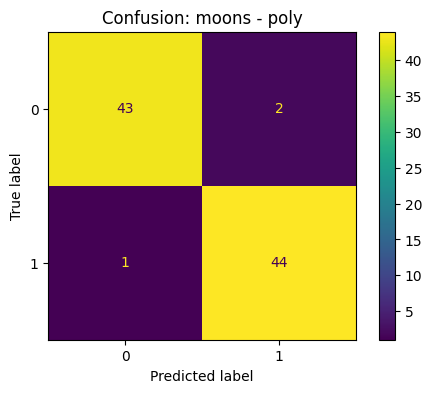


Dataset: circles

-- Kernel: linear
Best params: {'svc__C': 10, 'svc__kernel': 'linear'}  | CV acc: 0.48571428571428565  | Test acc: 0.4888888888888889


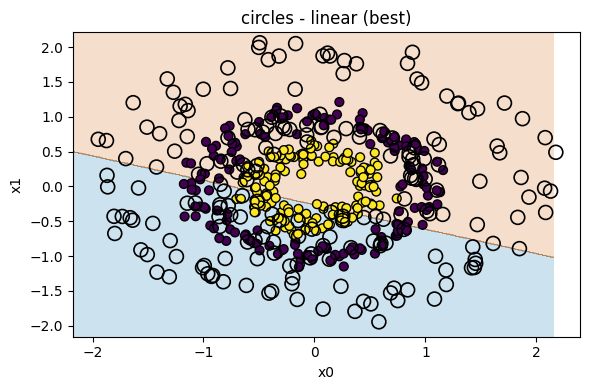

              precision    recall  f1-score   support

           0      0.483     0.311     0.378        45
           1      0.492     0.667     0.566        45

    accuracy                          0.489        90
   macro avg      0.487     0.489     0.472        90
weighted avg      0.487     0.489     0.472        90



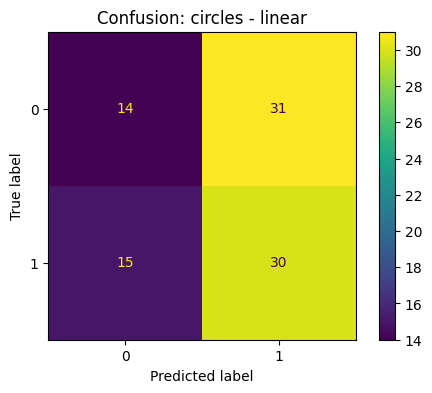


-- Kernel: rbf
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}  | CV acc: 1.0  | Test acc: 0.9888888888888889


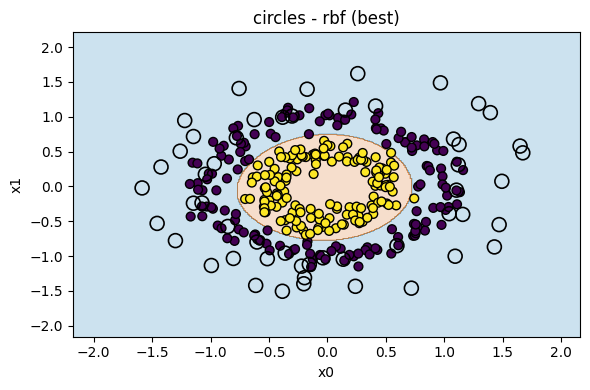

              precision    recall  f1-score   support

           0      0.978     1.000     0.989        45
           1      1.000     0.978     0.989        45

    accuracy                          0.989        90
   macro avg      0.989     0.989     0.989        90
weighted avg      0.989     0.989     0.989        90



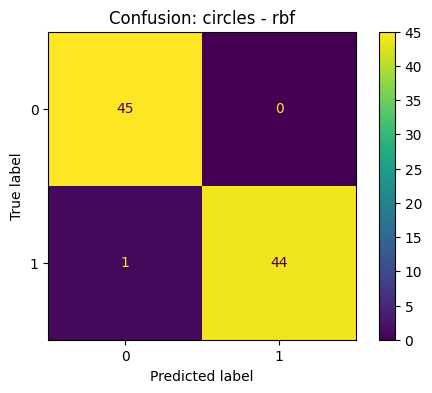


-- Kernel: poly
Best params: {'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}  | CV acc: 1.0  | Test acc: 0.9777777777777777


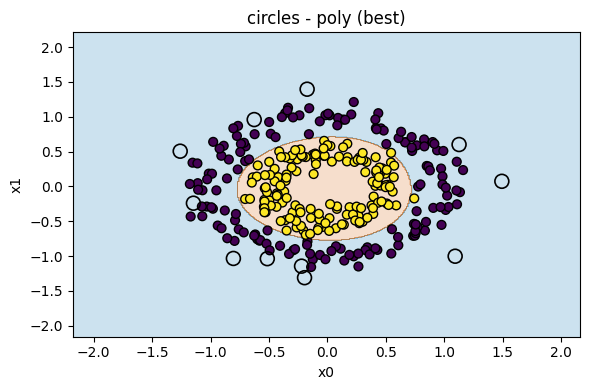

              precision    recall  f1-score   support

           0      0.957     1.000     0.978        45
           1      1.000     0.956     0.977        45

    accuracy                          0.978        90
   macro avg      0.979     0.978     0.978        90
weighted avg      0.979     0.978     0.978        90



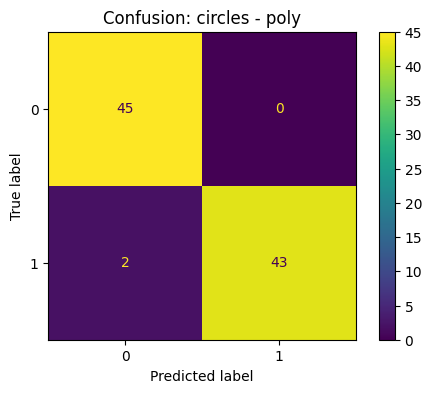


Dataset: blobs

-- Kernel: linear
Best params: {'svc__C': 100, 'svc__kernel': 'linear'}  | CV acc: 0.9714285714285715  | Test acc: 0.9777777777777777


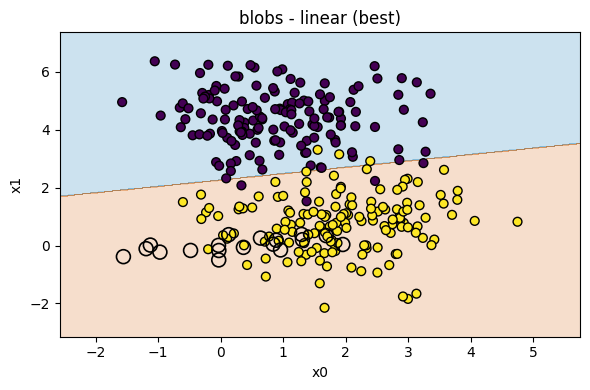

              precision    recall  f1-score   support

           0      0.978     0.978     0.978        45
           1      0.978     0.978     0.978        45

    accuracy                          0.978        90
   macro avg      0.978     0.978     0.978        90
weighted avg      0.978     0.978     0.978        90



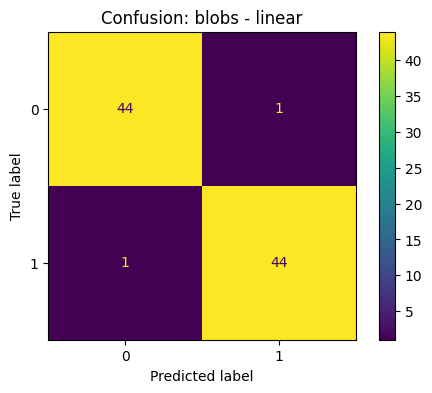


-- Kernel: rbf
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}  | CV acc: 0.980952380952381  | Test acc: 0.9555555555555556


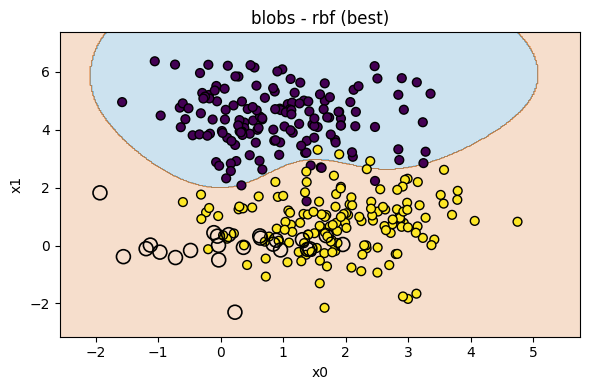

              precision    recall  f1-score   support

           0      0.977     0.933     0.955        45
           1      0.936     0.978     0.957        45

    accuracy                          0.956        90
   macro avg      0.956     0.956     0.956        90
weighted avg      0.956     0.956     0.956        90



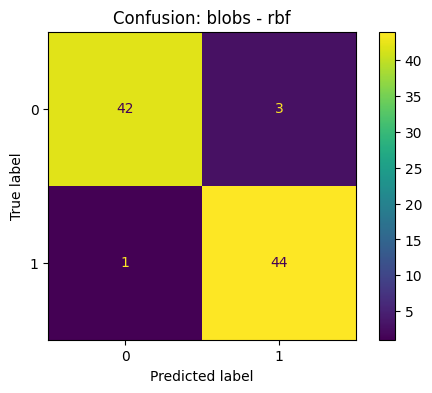


-- Kernel: poly
Best params: {'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree': 3, 'svc__gamma': 1, 'svc__kernel': 'poly'}  | CV acc: 0.9761904761904763  | Test acc: 0.9555555555555556


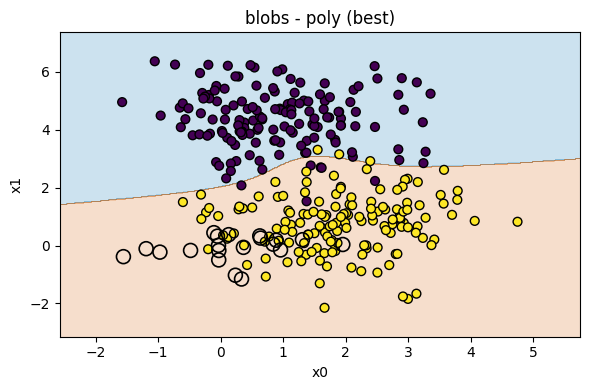

              precision    recall  f1-score   support

           0      0.977     0.933     0.955        45
           1      0.936     0.978     0.957        45

    accuracy                          0.956        90
   macro avg      0.956     0.956     0.956        90
weighted avg      0.956     0.956     0.956        90



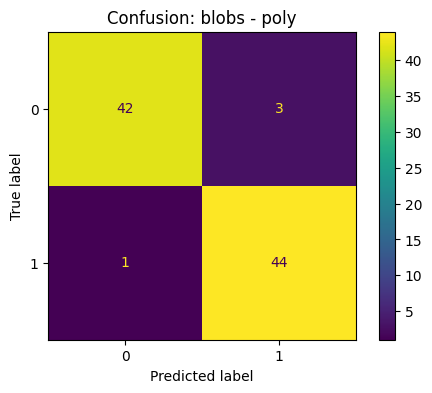

,dataset,kernel,best_params,cv_acc,test_acc,model,figure
0,blobs,linear,"{'svc__C': 100, 'svc__kernel': 'linear'}",0.971429,0.977778,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
1,blobs,rbf,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.980952,0.955556,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
2,blobs,poly,"{'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree...",0.976190,0.955556,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
3,circles,rbf,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,0.988889,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
4,circles,poly,"{'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree...",1.000000,0.977778,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
5,circles,linear,"{'svc__C': 10, 'svc__kernel': 'linear'}",0.485714,0.488889,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
6,moons,rbf,"{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...",0.985714,0.977778,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
7,moons,poly,"{'svc__C': 10, 'svc__coef0': 1.0, 'svc__degree...",0.985714,0.966667,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...
8,moons,linear,"{'svc__C': 0.01, 'svc__kernel': 'linear'}",0.866667,0.777778,/mnt/data/svm_submission_package/artifacts/mod...,/mnt/data/svm_submission_package/artifacts/bou...


In [ ]:
results = []
for dname,(X,y) in datasets.items():
    print('\n'+'='*50); print('Dataset:', dname)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=RANDOM_STATE)
    for kname, grid in param_grids.items():
        print('\n-- Kernel:', kname)
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=RANDOM_STATE))])
        gs = GridSearchCV(pipe, param_grid=grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)
        best = gs.best_estimator_
        test_acc = best.score(X_test, y_test)
        print('Best params:', gs.best_params_, ' | CV acc:', gs.best_score_, ' | Test acc:', test_acc)
        model_path = os.path.join(OUTDIR, f'model_{dname}_{kname}.joblib')
        joblib.dump(gs, model_path)
        fig_path = os.path.join(OUTDIR, f'boundary_{dname}_{kname}.png')
        plot_decision_boundary_and_support(best, X, y, title=f'{dname} - {kname} (best)', savepath=fig_path)
        y_pred = best.predict(X_test)
        print(classification_report(y_test, y_pred, digits=3))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(); plt.title(f'Confusion: {dname} - {kname}'); plt.savefig(os.path.join(OUTDIR,f'confusion_{dname}_{kname}.png'), dpi='figure', bbox_inches='tight'); plt.show()
        results.append({'dataset':dname,'kernel':kname,'best_params':gs.best_params_,'cv_acc':float(gs.best_score_),'test_acc':float(test_acc),'model':model_path,'figure':fig_path})
results_df = pd.DataFrame(results).sort_values(['dataset','test_acc'], ascending=[True,False]).reset_index(drop=True)
results_df.to_csv(os.path.join(OUTDIR,'results_summary.csv'), index=False)
results_df

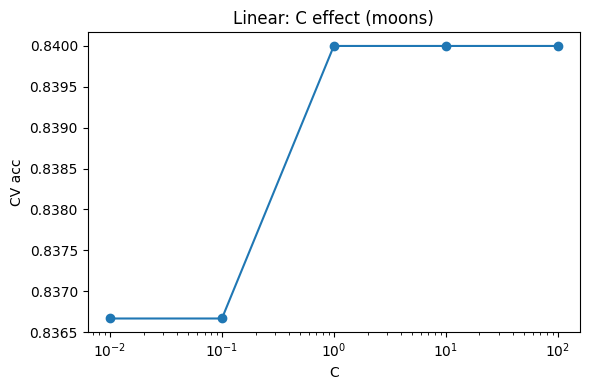

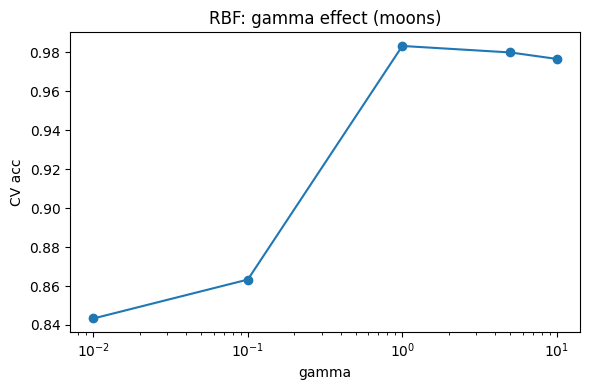

In [ ]:
X_m, y_m = datasets['moons']
linear_C = [0.01,0.1,1,10,100]
linear_scores = []
for C in linear_C:
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', C=C, random_state=RANDOM_STATE))])
    linear_scores.append(cross_val_score(pipe, X_m, y_m, cv=cv, scoring='accuracy', n_jobs=-1).mean())
plt.figure(); plt.plot(linear_C, linear_scores, marker='o'); plt.xscale('log'); plt.xlabel('C'); plt.ylabel('CV acc'); plt.title('Linear: C effect (moons)'); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'linear_C_effect.png'), dpi='figure', bbox_inches='tight'); plt.show()

rbf_gamma = [0.01,0.1,1,5,10]
rbf_scores = []
for g in rbf_gamma:
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=1, gamma=g, random_state=RANDOM_STATE))])
    rbf_scores.append(cross_val_score(pipe, X_m, y_m, cv=cv, scoring='accuracy', n_jobs=-1).mean())
plt.figure(); plt.plot(rbf_gamma, rbf_scores, marker='o'); plt.xscale('log'); plt.xlabel('gamma'); plt.ylabel('CV acc'); plt.title('RBF: gamma effect (moons)'); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'rbf_gamma_effect.png'), dpi='figure', bbox_inches='tight'); plt.show()

### List Saved Artifacts

Below are the files saved in the artifacts directory. You can find these files in the Colab file browser (left sidebar) under the `/mnt/data/svm_submission_package/artifacts` path. You can right-click on individual files to download them, or download the entire directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# List all files in the OUTDIR
print(f"Files saved in '{OUTDIR}':")
for root, dirs, files in os.walk(OUTDIR):
    for file in files:
        print(os.path.join(root, file))

Files saved in '/mnt/data/svm_submission_package/artifacts':
/mnt/data/svm_submission_package/artifacts/model_blobs_linear.joblib
/mnt/data/svm_submission_package/artifacts/boundary_circles_linear.png
/mnt/data/svm_submission_package/artifacts/confusion_moons_linear.png
/mnt/data/svm_submission_package/artifacts/model_moons_poly.joblib
/mnt/data/svm_submission_package/artifacts/dataset_circles.png
/mnt/data/svm_submission_package/artifacts/confusion_blobs_rbf.png
/mnt/data/svm_submission_package/artifacts/confusion_moons_rbf.png
/mnt/data/svm_submission_package/artifacts/model_blobs_rbf.joblib
/mnt/data/svm_submission_package/artifacts/confusion_circles_linear.png
/mnt/data/svm_submission_package/artifacts/model_moons_linear.joblib
/mnt/data/svm_submission_package/artifacts/dataset_blobs.png
/mnt/data/svm_submission_package/artifacts/dataset_moons.png
/mnt/data/svm_submission_package/artifacts/confusion_blobs_linear.png
/mnt/data/svm_submission_package/artifacts/boundary_blobs_rbf.png


## References & Further Reading

References
- Cortes, C. and Vapnik, V. (1995). Support-vector networks.
- scikit-learn documentation: https://scikit-learn.org/stable/modules/svm.html
- Schölkopf, B. & Smola, A. J. (2001). Learning with Kernels.



